# ECG Feature Comparison for SHAP - File name (Ecg Features Comparison Code)

## Imports

In [1]:
!pip install shap==0.46.0
import shap
import scipy
import numpy as np
import pandas as pd
!pip install tensorflow==2.15.0
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, load_model
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 13.2 MB/s eta 0:00:0000:01
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.7
    Uninstalling slicer-0.0.7:
      Successfully uninstalled slicer-0.0.7
  Attempting uninstall: shap
    Found existing installation: shap 0.44.1
    Uninstalling shap-0.44.1:
      Successfully uninstalled shap-0.44.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 72.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found exi

2024-10-24 18:27:56.507156: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 18:27:56.507238: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 18:27:56.508895: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Loading

### Model

In [2]:
# Load the trained Keras model
model = load_model('/kaggle/input/6-data-for-explainableai/baseline_model.h5', compile=False)
# del model

### Data

In [3]:
data_test = pd.read_csv('/kaggle/input/6-data-for-explainableai/data_test.csv')
data_train = pd.read_csv('/kaggle/input/6-data-for-explainableai/data_train.csv')
data_val = pd.read_csv('/kaggle/input/6-data-for-explainableai/data_val.csv')

labels_test = pd.read_csv('/kaggle/input/6-data-for-explainableai/labels_test.csv')
labels_train = pd.read_csv('/kaggle/input/6-data-for-explainableai/labels_train.csv')
labels_val = pd.read_csv('/kaggle/input/6-data-for-explainableai/labels_val.csv')

## Create data generators

In [4]:
# This class is a customer data generator 
# It's purpose is to load, preprocess and supply data in batches during training
# It's there because it is inefficient to load large datasets at once
    
class ECG_DataGen(tf.keras.utils.Sequence):    
# Contructor - Takes a list of ECG files and labels, batch size (number of samples ), sample length (number of data points in each ECG signal), and an option to shuffle the data. 
    def __init__(self, df_files, df_labels, data_col, batch_size, sample_len, shuffle=True):
        #self is an instance of the class #it should be passed as first parameter in all methods
        
        self.df_files = df_files.copy()
        self.df_labels = df_labels.copy()
        self.data_col = data_col
        self.n_samples = len(self.df_files)
        self.sample_len = sample_len
        self.batch_size = batch_size
        self.shuffle = shuffle
        
    def __len__(self):
        return self.n_samples // self.batch_size
    
#     applies low pass filter
    def low_pass_filter(self, voltages, window_size):
        """Applies a moving average low-pass filter to a 1D array of voltages."""
        # Create a windowed version of the array
        window = np.ones(window_size) / window_size
        filtered_voltages = np.convolve(voltages, window, mode='same')
        return filtered_voltages
    
#    normalizes data and apply low pass filter
    def scale(self, array):
        # Replace NaN values with 0.0
        array = np.nan_to_num(array, nan=0.0)
        
        #apply low pass filter
        array = self.low_pass_filter(array, window_size=100)

        # normalizing
        a_min = np.min(array)
        a_max = np.max(array)
        if a_max - a_min == 0:
            return np.zeros_like(array).reshape((-1, 1))
        return np.array((array - a_min) / (a_max - a_min))
       
#   TO BE SEARCHED  -  loads, preprocesses (filters and normalizes), and formats the data in chunks (batches) and returns it to the model.    
    def __getitem__(self, index):
        batch_leads = np.zeros((self.batch_size, self.sample_len, 12)) #create array with shape 128, 5000, 12
        batch_labels = np.zeros((self.batch_size, len(self.df_labels.columns))) 

        for i in range(index*self.batch_size, (index+1)*self.batch_size):

            # load the ECG signals
            leads = scipy.io.loadmat(self.df_files.at[i, self.data_col])['val'] #loadmat() is a function to load matlab files #self.df_files.at[i, self.data_col] is the file path
            
            for j, lead_data in enumerate(leads): #iterate through 12 leads
                #preprocess data (normalize, filter)
                scaled_lead_data = self.scale(lead_data)
                
                batch_leads[i - index*self.batch_size, :, j] = scaled_lead_data.reshape((-1,))
            batch_labels[i - index*self.batch_size] = self.df_labels.loc[i].values

        return batch_leads, batch_labels

    #  called at the end of every training epoch to shuffle data after every epoch
    def on_epoch_end(self):
        if self.shuffle: 
            shuffle_idx = np.random.choice(range(self.n_samples), size=self.n_samples, replace=False)
            self.df_files = self.df_files.iloc[shuffle_idx].reset_index(drop=True)
            self.df_labels = self.df_labels.iloc[shuffle_idx].reset_index(drop=True)

In [5]:
data_col = 'ecg_filename'
sample_len = 5000
batch_size= 128

# Create data generators (Objects from ECG_DataGen class)
# These generators do not store the data themselves; instead, they load, preprocess, and return batches of ECG data and corresponding labels during model training or evaluation.
train_gen = ECG_DataGen(data_train, labels_train, data_col, batch_size, sample_len)
val_gen = ECG_DataGen(data_val, labels_val, data_col, batch_size, sample_len)
test_gen = ECG_DataGen(data_test, labels_test, data_col, len(data_test), sample_len)

In [6]:
# Extract a batch of data
X, _ = train_gen.__getitem__(0)  # Get the first batch
X.shape

(128, 5000, 12)

In [7]:
# Select a subset of the data for explanation
X_sample = X[:50]  # Take first 10 samples as an example
X_sample.shape

(50, 5000, 12)

## Deep explainer

In [8]:
prediction = model.predict(X_sample[:1])
predicted_disease_index = np.argmax(prediction)
disease = labels_train.columns[predicted_disease_index]
probability = np.max(prediction)*100

print('Predicted disease:', disease)
print('Probability:', probability)

1/1 [==============================] - 0s 143ms/step
Predicted disease: SR
Probability: 80.47813773155212


In [11]:
# Use the DeepExplainer for deep learning models
e2 = shap.DeepExplainer(model, X_sample)

/opt/conda/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


In [12]:
shap_values2 = e2.shap_values(X_sample[:1])
shap_values2.shape

/opt/conda/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


(1, 5000, 12, 20)

Delete

In [19]:
shap_values = shap_values2
ecg_input = X_sample[:1]
ecg_input[:1].shape

(1, 5000, 12)

In [22]:
prediction = model.predict(ecg_input)
predicted_disease_index = np.argmax(prediction)
predicted_disease_index

1/1 [==============================] - 0s 38ms/step


19

In [24]:
filtered_shap_values = []
for lead in range(12):
    shap_vals_for_disease = shap_values[0][:, lead, predicted_disease_index]
    important_time_points = np.where(np.abs(shap_vals_for_disease) > shap_threshold)[0]
    filtered_shap_values.append({
        "lead": lead + 1,
        "important_time_points": important_time_points.tolist(),
        "shap_values": shap_vals_for_disease[important_time_points].tolist()
    })

In [28]:
len(filtered_shap_values[0])

3

In [42]:
lead_to_check = 1
total = 0
for lead_to_check in range(12):
    # Iterate through the filtered_shap_values to find the specific lead
    for entry in filtered_shap_values:
        if entry["lead"] == lead_to_check:
            important_points_count = len(entry["important_time_points"])
            print(f"Lead {lead_to_check} has {important_points_count} important SHAP values.")
            total += important_points_count
            break
    else:
        print(f"Lead {lead_to_check} not found.")

print('Total:', total)


Lead 0 not found.
Lead 1 has 457 important SHAP values.
Lead 2 has 487 important SHAP values.
Lead 3 has 521 important SHAP values.
Lead 4 has 529 important SHAP values.
Lead 5 has 506 important SHAP values.
Lead 6 has 563 important SHAP values.
Lead 7 has 513 important SHAP values.
Lead 8 has 386 important SHAP values.
Lead 9 has 462 important SHAP values.
Lead 10 has 665 important SHAP values.
Lead 11 has 440 important SHAP values.
Total: 5529


In [31]:
filtered_shap_values[0]

{'lead': 1,
 'important_time_points': [40,
  48,
  61,
  93,
  103,
  104,
  117,
  118,
  119,
  123,
  125,
  129,
  135,
  137,
  138,
  145,
  147,
  149,
  154,
  155,
  163,
  167,
  171,
  175,
  179,
  183,
  184,
  185,
  187,
  189,
  191,
  192,
  193,
  199,
  203,
  204,
  208,
  209,
  210,
  212,
  215,
  216,
  217,
  446,
  448,
  479,
  480,
  717,
  718,
  727,
  847,
  851,
  853,
  854,
  855,
  859,
  863,
  869,
  871,
  879,
  881,
  882,
  883,
  885,
  887,
  888,
  891,
  895,
  1139,
  1141,
  1142,
  1143,
  1144,
  1146,
  1147,
  1151,
  1154,
  1574,
  1616,
  1626,
  1644,
  1646,
  1650,
  1665,
  1667,
  1668,
  1669,
  1682,
  1684,
  1690,
  1701,
  1703,
  1706,
  1708,
  1710,
  1711,
  1716,
  1724,
  1736,
  1917,
  1919,
  1921,
  1923,
  1933,
  1942,
  1946,
  1947,
  1948,
  1950,
  1952,
  1954,
  1957,
  1959,
  1961,
  1963,
  1964,
  1965,
  1966,
  1967,
  1968,
  1971,
  2030,
  2037,
  2040,
  2042,
  2044,
  2046,
  2048,
  2160,
  2

Delete

### Highlighting the Most Important Regions in the ECG Signal

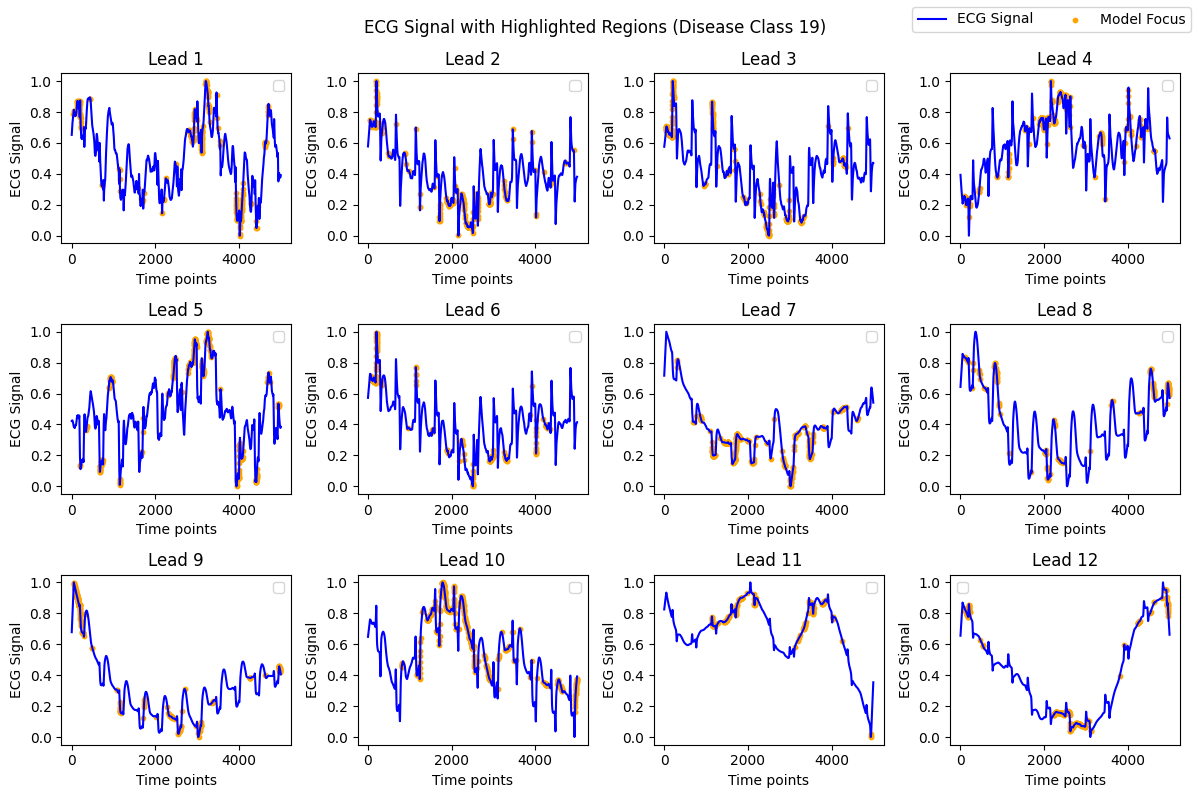

In [40]:
# For a given ECG record (e.g., record 0)
record_idx = 0
disease_class = predicted_disease_index

# Define a threshold for SHAP values to highlight important regions
shap_threshold = np.percentile(shap_values2[record_idx][:, :, disease_class], 95)  # Top 5% most important points

# Plot the ECG signal with highlighted regions where SHAP values are above the threshold
plt.figure(figsize=(12, 8))

for lead in range(12):
    plt.subplot(3, 4, lead + 1)
    
    # Get the ECG signal for this lead
    ecg_signal = X_sample[record_idx][:, lead]
    
    # Get the SHAP values for this lead and disease
    shap_vals_for_disease = shap_values2[record_idx][:, lead, disease_class]
    
    # Plot the ECG signal
    plt.plot(ecg_signal, color='blue')
    
    # Highlight the regions where SHAP values are high (above the threshold)
    important_time_points = np.where(shap_vals_for_disease> shap_threshold)[0]
    plt.scatter(important_time_points, ecg_signal[important_time_points], color='orange', s=10)
    plt.title(f'Lead {lead + 1}')
    plt.xlabel('Time points')
    plt.ylabel('ECG Signal')
    plt.legend()
plt.figlegend(['ECG Signal', 'Model Focus'], loc='upper right', ncol=2)
plt.suptitle(f'ECG Signal with Highlighted Regions (Disease Class {disease_class})')
# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

### ECG Features Comparison with Doctor's Features

#### Creating Knowledge base

In [13]:
# Creating a Knowledge Base of Doctors' Features for Specific Diseases
print("Creating knowledge base of doctors' features for specific cardiac conditions...")
knowledge_base = {
    'ISCAL': {
        'full_name': 'Ischemic in Anterolateral Leads',
        'leads': ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'I', 'aVL'],
        'features': ['ST-segment elevation or depression', 'Pathological Q waves in chronic phase']
    },
    'NST': {
        'full_name': 'Non-Specific ST Changes',
        'leads': 'all',
        'features': ['ST-segment depression or elevation without clear ischemic pattern']
    },
    'SARRH': {
        'full_name': 'Sinus Arrhythmia',
        'leads': 'all',
        'features': ['Irregular R-R intervals', 'Normal P waves']
    },
    'IVCD': {
        'full_name': 'Non-Specific Intraventricular Conduction Disturbances',
        'leads': 'all',
        'features': ['Prolongation of QRS complex (>0.12 seconds)', 'Abnormal QRS morphology']
    },
    '1AVB': {
        'full_name': 'First-Degree AV Block',
        'leads': 'all',
        'features': ['Prolongation of PR interval (>200 ms)', 'P waves followed by QRS complexes']
    },
    'STACH': {
        'full_name': 'Sinus Tachycardia',
        'leads': 'all',
        'features': ['Increased heart rate (>100 bpm)', 'Normal P wave morphology preceding each QRS']
    },
    'VCLVH': {
        'full_name': 'Left Ventricular Hypertrophy',
        'leads': ['V1', 'V2', 'V3', 'V4', 'V5', 'V6'],
        'features': ['Increased QRS voltage', 'Sokolow-Lyon criteria', 'Left axis deviation', 'ST depression', 'T wave inversion']
    },
    'AFIB': {
        'full_name': 'Atrial Fibrillation',
        'leads': 'all',
        'features': ['Irregularly irregular rhythm', 'Absence of distinct P waves']
    },
    'NSIC': {
        'full_name': 'Non-Specific Ischemic Changes',
        'leads': 'all',
        'features': ['Subtle or diffuse ST-segment changes', 'T-wave flattening or inversion']
    },
    'IMI': {
        'full_name': 'Inferior Myocardial Infarction',
        'leads': ['II', 'III', 'aVF'],
        'features': ['ST-segment elevation in leads II, III, and aVF', 'Reciprocal changes in leads I and aVL']
    }
}

Creating knowledge base of doctors' features for specific cardiac conditions...


In [15]:
disease_code = "ISCAL"
doctor_criteria = knowledge_base.get(disease_code, {})
doctor_criteria

doctor_leads = set(doctor_criteria.get('leads', []))
doctor_leads

{'I', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'aVL'}

In [20]:
record_idx = 0
shap_values = shap_values2
threshold = 95

In [18]:
# Extract SHAP values for the specific record and disease
shap_values_record = shap_values[record_idx]  # Shape: (5000, 12, 20)
disease_idx = list(knowledge_base.keys()).index(disease_code)  # Find the index of the specific disease
shap_values_disease = shap_values_record[:, :, disease_idx]  # Shape: (5000, 12) # SHAP Values for specific disease

In [21]:
# Calculate threshold to identify the most important features
shap_threshold = np.percentile(shap_values_disease, threshold) #shap_threshold holds a single value
shap_threshold

3.397832868009497e-06

In [22]:
important_points = shap_values_disease > shap_threshold
print('Important points shape: ', important_points.shape)

Important points shape:  (5000, 12)


In [23]:
important_points

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [26]:
# Identify leads with important features
model_leads = set()
for lead_idx in range(important_points.shape[1]):
    if np.any(important_points[:, lead_idx]):
        model_leads.add(f'Lead {lead_idx + 1}')

In [27]:
model_leads

{'Lead 1',
 'Lead 10',
 'Lead 11',
 'Lead 12',
 'Lead 2',
 'Lead 3',
 'Lead 4',
 'Lead 5',
 'Lead 6',
 'Lead 7',
 'Lead 8',
 'Lead 9'}

In [14]:
lead_mapping = {
    'Lead 1': 'I',
    'Lead 2': 'II',
    'Lead 3': 'III',
    'Lead 4': 'aVR',
    'Lead 5': 'aVL',
    'Lead 6': 'aVF',
    'Lead 7': 'V1',
    'Lead 8': 'V2',
    'Lead 9': 'V3',
    'Lead 10': 'V4',
    'Lead 11': 'V5',
    'Lead 12': 'V6'
}

In [35]:
transformed_leads = {lead_mapping[lead] for lead in model_leads}
transformed_leads

{'I', 'II', 'III', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'aVF', 'aVL', 'aVR'}

In [36]:
# Check for lead overlap
matching_leads = doctor_leads.intersection(transformed_leads)
doctor_leads_count = len(doctor_leads)
matching_leads_count = len(matching_leads)

In [37]:
doctor_leads_count

8

In [38]:
matching_leads_count

8

#### Comparison Function

In [15]:
# Function to Compare Model-Highlighted Features with Knowledge Base
print("Defining the comparison function...")

def compare_model_vs_doctor(shap_values, record_idx, disease_code, threshold=95):
    print(f"Comparing model-highlighted features for record index {record_idx} and disease code '{disease_code}'...")

    # Get all JSON details from JSON variable based on disease_code
    doctor_criteria = knowledge_base.get(disease_code, {})  # {} means if nothing is found, {} is returned as default value
    print(f"Doctor criteria for disease code '{disease_code}': {doctor_criteria}")

    # Check if there is anything in doctor_criteria
    if not doctor_criteria:
        print(f"No criteria found for disease code: {disease_code}")
        return None

    doctor_leads = set(doctor_criteria.get('leads', []))  # [] means if nothing is found, [] is returned as default value
    print(f"Leads expected by doctors: {doctor_leads}")

    # Extract SHAP values for the specific record and disease
    shap_values_record = shap_values[record_idx]  # Shape: (5000, 12, 20)
    print(f"SHAP values for record index {record_idx} extracted. Shape: {shap_values_record.shape}")
    
    disease_idx = list(knowledge_base.keys()).index(disease_code)  # Find the index of the specific disease
    print(f"Index of disease '{disease_code}' in knowledge base: {disease_idx}")

    shap_values_disease = shap_values_record[:, :, disease_idx]  # Shape: (5000, 12)
    print(f"SHAP values for disease '{disease_code}' extracted. Shape: {shap_values_disease.shape}")

    # Calculate threshold to identify the most important features
    shap_threshold = np.percentile(shap_values_disease, threshold)  # shap_threshold holds a single value
    print(f"SHAP value threshold (top {threshold}%): {shap_threshold}")

    important_points = shap_values_disease > shap_threshold

    # Identify leads with important features
    sequential_leads = set()
    for lead_idx in range(important_points.shape[1]):
        if np.any(important_points[:, lead_idx]):
            sequential_leads.add(f'Lead {lead_idx + 1}')
    print(f"Sequential leads identified by the model: {sequential_leads}")

    model_leads = {lead_mapping[lead] for lead in sequential_leads}
    print(f"Model-highlighted leads after mapping: {model_leads}")

    # Check for lead overlap
    matching_leads = doctor_leads.intersection(model_leads)
    print(f"Matching leads between doctor and model: {matching_leads}")

    doctor_leads_count = len(doctor_leads)
    matching_leads_count = len(matching_leads)

    # Results analysis with detailed reasoning
    print("\nThese are the leads that should be highlighted according to medical knowledge:", doctor_leads)
    print("These are the leads that the model highlighted:", model_leads)

    if matching_leads_count == doctor_leads_count:
        print("All doctor's leads are present in the model-highlighted leads.")
        return f"Accurate: All {matching_leads_count} out of {doctor_leads_count} leads matched."
    elif matching_leads_count >= 0.8 * doctor_leads_count:
        missing_leads = doctor_leads - model_leads
        print(f"At least 80% of the doctor's leads are present. Matching leads: {matching_leads}, Missing leads: {missing_leads}")
        return f"Mostly Accurate: {matching_leads_count} out of {doctor_leads_count} leads matched. Missing leads: {missing_leads}."
    elif matching_leads_count >= 0.5 * doctor_leads_count:
        missing_leads = doctor_leads - model_leads
        print(f"At least 50% of the doctor's leads are present. Matching leads: {matching_leads}, Missing leads: {missing_leads}")
        return f"Partially Accurate: {matching_leads_count} out of {doctor_leads_count} leads matched. Missing leads: {missing_leads}."
    elif matching_leads_count > 0:
        missing_leads = doctor_leads - model_leads
        print(f"Less than 50% of the doctor's leads are present. Matching leads: {matching_leads}, Missing leads: {missing_leads}")
        return f"Needs Verification: {matching_leads_count} out of {doctor_leads_count} leads matched. Missing leads: {missing_leads}."
    else:
        print("No leads match between the model-highlighted leads and doctor's leads.")
        return "Verification is advised: No leads matched."

Defining the comparison function...


#### Testing

In [16]:
# Example usage of the comparison function
print("Running an example comparison...")
# Mock SHAP values for demonstration
# shap_values_mock = np.random.rand(10, 5000, 12, 20)  # Shape: (10 records, 5000 time points, 12 leads, 20 diseases)
shap_values_mock = shap_values2

record_idx = 0
disease_code = 'ISCAL'
print(f"Using record index: {record_idx}, disease code: '{disease_code}'")
result = compare_model_vs_doctor(shap_values_mock, record_idx, disease_code)
print(f"Comparison result: {result}")

Running an example comparison...
Using record index: 0, disease code: 'ISCAL'
Comparing model-highlighted features for record index 0 and disease code 'ISCAL'...
Doctor criteria for disease code 'ISCAL': {'full_name': 'Ischemic in Anterolateral Leads', 'leads': ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'I', 'aVL'], 'features': ['ST-segment elevation or depression', 'Pathological Q waves in chronic phase']}
Leads expected by doctors: {'V3', 'V4', 'V1', 'I', 'V2', 'aVL', 'V6', 'V5'}
SHAP values for record index 0 extracted. Shape: (5000, 12, 20)
Index of disease 'ISCAL' in knowledge base: 0
SHAP values for disease 'ISCAL' extracted. Shape: (5000, 12)
SHAP value threshold (top 95%): 9.508821875106406e-06
Sequential leads identified by the model: {'Lead 9', 'Lead 1', 'Lead 4', 'Lead 5', 'Lead 8', 'Lead 11', 'Lead 10', 'Lead 7', 'Lead 12', 'Lead 6', 'Lead 3', 'Lead 2'}
Model-highlighted leads after mapping: {'V3', 'V4', 'V1', 'aVR', 'I', 'V2', 'aVL', 'aVF', 'III', 'V6', 'V5', 'II'}
Matching lead